In [2]:
import requests
import pandas as pd
from datetime import datetime
from io import StringIO
from dask import delayed, compute
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import math
import os

In [143]:
TRADIER_TOKEN = "fBPJduZqJD4SquxQi3rRlRELBORS"  # from https://developer.tradier.com/
API_URL       = "https://api.tradier.com/v1"
HEADERS       = {
    "Authorization": f"Bearer {TRADIER_TOKEN}",
    "Accept":        "application/json"
}
CONTRACT_MULTIPLIER=100
DATE='2025-05-09'
TICKER = "SPY"
CACHE_FILE=f"net_gamma_cache_{TICKER}.csv"
OFFSET=200 if TICKER=="SPX" else 25

In [144]:
def get_expiration_dates(ticker):
    """
    Fetch the list of expiration dates for the given ticker.
    """
    url = f"{API_URL}/markets/options/expirations"
    resp = requests.get(url, params={"symbol": ticker, "includeAllRoots" : "true"}, headers=HEADERS)
    resp.raise_for_status()
    data = resp.json()
    # Tradier returns { "expirations": { "date": ["2025-05-16", "2025-05-23", …] } }
    return data.get("expirations", {}).get("date", [])


def get_option_chain(ticker, expiration=None):
    """
    Fetch the option chain for a ticker.
    If expiration is None, returns the entire chain (all expirations).
    Otherwise returns only that date’s options.
    """
    url = f"{API_URL}/markets/options/chains"
    params = {
        "symbol":     ticker,
        "expiration": expiration,
        "includeAllRoots" : "true",
        "greeks":     "true"      # ← ask for greeks
    } 
    if expiration:
        params["expiration"] = expiration
    resp = requests.get(url, params=params, headers=HEADERS)
    resp.raise_for_status()
    data = resp.json()
    # Tradier returns { "options": { "option": [ { … }, { … } ] } }
    return data.get("options", {}).get("option", [])

# 1) Get expirations
expirations = get_expiration_dates(TICKER)
print("Available expirations:", expirations)

# 2) Choose one (e.g., the first)
selected = expirations[0] if expirations else None
if not selected:
    raise SystemExit("No expirations available.")

print(f"\nFetching chain for {TICKER} expiring {selected}…")
chain = get_option_chain(TICKER, selected)
# chain = get_option_chain(TICKER, DATE)

Available expirations: ['2025-05-09', '2025-05-12', '2025-05-13', '2025-05-14', '2025-05-15', '2025-05-16', '2025-05-19', '2025-05-20', '2025-05-21', '2025-05-22', '2025-05-23', '2025-05-30', '2025-06-06', '2025-06-13', '2025-06-20', '2025-06-27', '2025-06-30', '2025-07-18', '2025-07-31', '2025-08-15', '2025-08-29', '2025-09-19', '2025-09-30', '2025-10-31', '2025-12-19', '2025-12-31', '2026-01-16', '2026-03-20', '2026-03-31', '2026-06-18', '2026-12-18', '2027-01-15', '2027-12-17']

Fetching chain for SPY expiring 2025-05-09…


In [145]:

def get_options_for_date(option_data, selected_date):
    """
    Tradier’s chains endpoint returns a flat list of options,
    each with an 'expiration_date' field. Filter by the date.
    """
    return [opt for opt in option_data if opt.get("expiration_date") == selected_date]

def display_options(options_list):
    """
    Pretty-print the first few rows of a Tradier option list.
    Uses tabulate for a clean console table.
    """
    if not options_list:
        print("No options found for this date.")
        return

    # 1) Load into a DataFrame
    df = pd.DataFrame(options_list)

    # 2) Rename to match your legacy names
    df = df.rename(columns={
        "symbol":          "Contract",
        "option_type":     "Type",
        "strike":          "Strike",
        "last":            "Last",
        "bid":             "Bid",
        "ask":             "Ask",
        "volume":          "Volume",
        "open_interest":   "Open Interest",
        "contract_size":   "Multiplier"
    })

    # 3) Pick only the columns you care about (in order)
    cols = [
        "Contract", "Type", "Strike",
        "Last", "Bid", "Ask",
        "Volume", "Open Interest", "Multiplier"
    ]
    # drop any that aren’t actually present
    cols = [c for c in cols if c in df.columns]

    pretty_df = df[cols].head(10)  # show up to 10 rows

    # 4) Print with tabulate
    print(tabulate(pretty_df, headers="keys", tablefmt="fancy_grid", showindex=False))

options_list = get_options_for_date(chain, DATE)
# options_list
display_options(options_list)

╒════════════════════╤════════╤══════════╤════════╤════════╤════════╤══════════╤═════════════════╤══════════════╕
│ Contract           │ Type   │   Strike │   Last │    Bid │    Ask │   Volume │   Open Interest │   Multiplier │
╞════════════════════╪════════╪══════════╪════════╪════════╪════════╪══════════╪═════════════════╪══════════════╡
│ SPY250509P00250000 │ put    │      250 │   0.01 │   0    │   0.01 │        1 │            1902 │          100 │
├────────────────────┼────────┼──────────┼────────┼────────┼────────┼──────────┼─────────────────┼──────────────┤
│ SPY250509C00250000 │ call   │      250 │ 314.61 │ 313.69 │ 315.26 │        4 │              30 │          100 │
├────────────────────┼────────┼──────────┼────────┼────────┼────────┼──────────┼─────────────────┼──────────────┤
│ SPY250509P00255000 │ put    │      255 │ nan    │   0    │   0.01 │        0 │               0 │          100 │
├────────────────────┼────────┼──────────┼────────┼────────┼────────┼──────────┼────────

In [146]:
def get_stock_quote(ticker):
    """
    Fetch the current stock quote for `ticker` from Tradier.
    Returns a dict with fields like: { 'symbol':..., 'last':..., 'bid':..., 'ask':..., 'change':..., ... }
    """
    url = f"{API_URL}/markets/quotes"
    params = {"symbols": ticker}
    resp = requests.get(url, params=params, headers=HEADERS)
    resp.raise_for_status()
    data = resp.json()

    # Tradier returns { "quotes": { "quote": { ... } } } when you request one symbol
    quote = data.get("quotes", {}).get("quote")
    if isinstance(quote, list):
        # if you passed multiple symbols, it'll be a list—take the first
        quote = quote[0]
    return quote

def get_option_greeks(ticker, expiration, strike, option_type):
    """
    Fallback: fetch greeks for one contract if chain didn’t include greeks.
    """
    url = f"{API_URL}/markets/options/greeks"
    params = {
        "symbol":      ticker,
        "expiration":  expiration,
        "strike":      strike,
        "option_type": option_type
    }
    resp = requests.get(url, params=params, headers=HEADERS)
    resp.raise_for_status()
    g = resp.json().get("greeks", {})
    return g.get("gamma", None)

quote = get_stock_quote(TICKER)
print(quote)
S = quote.get('last')
if S is None:
    raise RuntimeError("Failed to retrieve last price")

print(f"Last {TICKER} price: {S}")

def compute_gamma_exposure(chain, S, T):
    rows = []
    for opt in chain:
        K    = opt["strike"]
        # filter by S±OFFSET
        if not (S - OFFSET <= K <= S + OFFSET):
            continue

        oi   = opt.get("open_interest", 0)
        # Try to grab gamma from the chain payload
        greeks = opt.get("greeks", {})
        gamma = greeks.get("gamma")

        # If it's still None, fetch it individually
        if gamma is None:
            gamma = get_option_greeks(
                TICKER, DATE, K, opt["option_type"]
            )

        if gamma is None:
            continue  # skip if we truly have no gamma

        # Gamma Exposure = gamma × open interest × contract multiplier
        gex = gamma * oi * CONTRACT_MULTIPLIER
        rows.append({
            "Strike":         K,
            "Gamma Exposure": gex,
            "Option Type":    opt["option_type"].upper(),
            "OI":             oi,
            "Gamma":          gamma
        })

    return pd.DataFrame(rows)

exp_date = datetime.strptime(DATE, "%Y-%m-%d")
T = (exp_date - datetime.today()).days / 365.0

df_gex = compute_gamma_exposure(chain, S, T)
df_gex.info()

{'symbol': 'SPY', 'description': 'SPDR S&P 500', 'exch': 'P', 'type': 'etf', 'last': 564.43, 'change': -0.63, 'volume': 22905270, 'open': 566.48, 'high': 567.5, 'low': 562.7637, 'close': None, 'bid': 564.43, 'ask': 564.45, 'change_percentage': -0.12, 'average_volume': 75910476, 'last_volume': 1000, 'trade_date': 1746814739903, 'prevclose': 565.06, 'week_52_high': 613.23, 'week_52_low': 481.8, 'bidsize': 5, 'bidexch': 'Q', 'bid_date': 1746814741000, 'asksize': 2, 'askexch': 'P', 'ask_date': 1746814741000, 'root_symbols': 'SPY'}
Last SPY price: 564.43
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Strike          112 non-null    float64
 1   Gamma Exposure  112 non-null    float64
 2   Option Type     112 non-null    object 
 3   OI              112 non-null    int64  
 4   Gamma           112 non-null    float64
dtypes: float64(3), int64

In [147]:
# Create a DataFrame, sort by strike, and aggregate if multiple entries exist per strike
df = df_gex
df_call = df[df['Option Type'] == 'CALL'].set_index('Strike')
df_put = df[df['Option Type'] == 'PUT'].set_index('Strike')
df_net = df_call['Gamma Exposure'].sub(df_put['Gamma Exposure'], fill_value=0).reset_index()
df_net.columns = ['Strike', 'Net GEX']

df_net = df_net.sort_values("Strike")
df_agg = df_net.groupby("Strike", as_index=False).sum()

/tmp/ipykernel_34454/2358518236.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


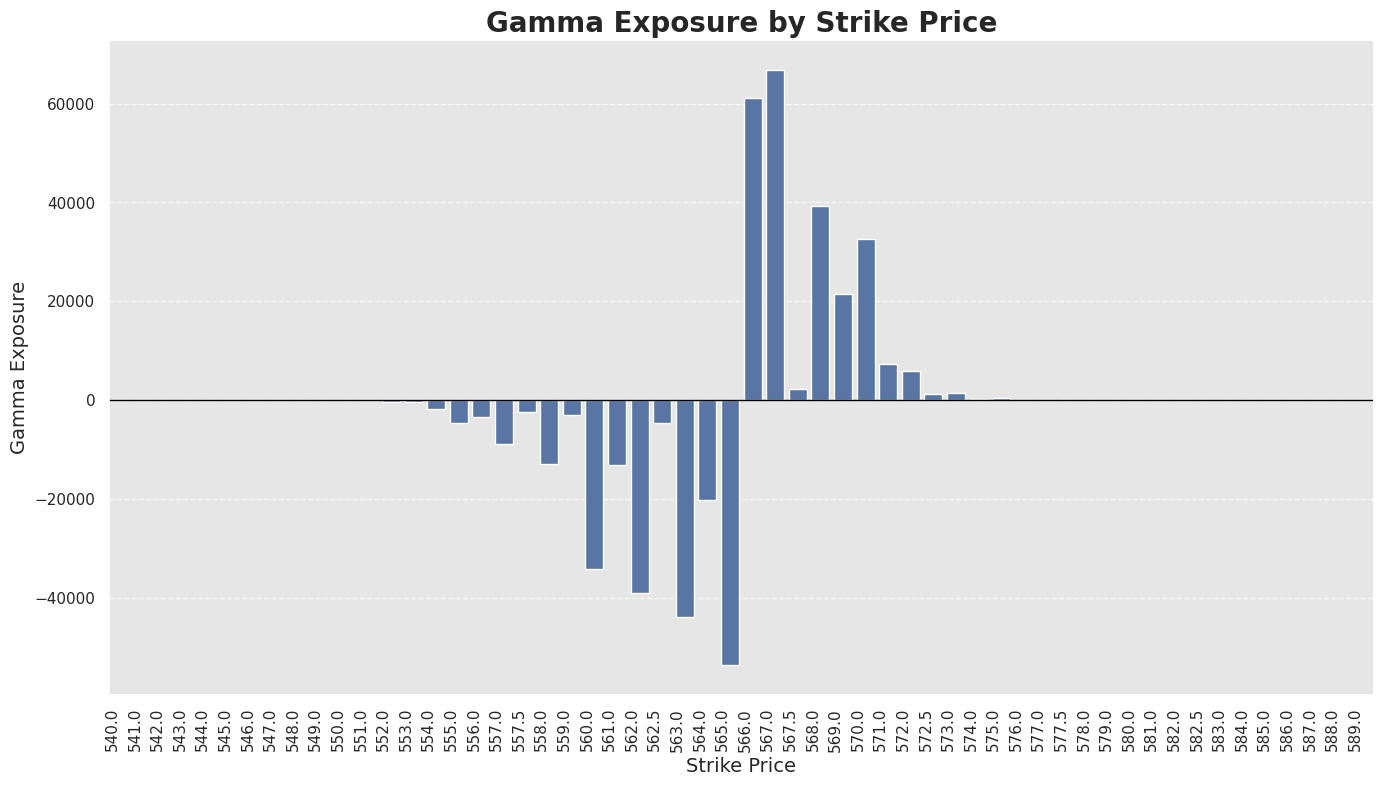

In [148]:
plt.figure(figsize=(14, 8))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# Plot
ax = sns.barplot(x="Strike", y="Net GEX", data=df_net)
# ax = sns.barplot(x="Strike", y="OI", data=df, hue='Option Type')

# Enhancing the appearance
ax.set_title("Gamma Exposure by Strike Price", fontsize=20, weight='bold')
ax.set_xlabel("Strike Price", fontsize=14)
ax.set_ylabel("Gamma Exposure", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()

# Adding grid
plt.grid(visible=True, which='major', axis='y', linestyle='--', alpha=0.7)

# Optional: Add a line at y=0 for clarity
plt.axhline(0, color='black', linewidth=1)

plt.xticks(rotation=90)
plt.show()

### Interperatation


In [149]:
def interpret_net_gex(df_net, S):
    """
    Returns a list of strings with automated interpretation:
     - magnet strike(s)
     - expected mean‐reversion/trend bias
     - steep GEX slope zones
     - gamma‐flip strikes
    """
    interp = []
    strikes = df_net["Strike"].values
    gex_vals = df_net["Net GEX"].values

    # 1) Magnet (max GEX)
    idx_max = gex_vals.argmax()
    magnet = strikes[idx_max]
    interp.append(f"🔴 Peak Net GEX at strike {magnet:.1f}")

    # 2) Bias: price vs magnet
    if S < magnet:
        interp.append(f"⚠️ Price {S:.2f} is below the magnet → mild upward bias (mean‐revert toward {magnet:.1f})")
    elif S > magnet:
        interp.append(f"⚠️ Price {S:.2f} is above the magnet → mild downward bias (mean‐revert toward {magnet:.1f})")
    else:
        interp.append(f"⚖️ Price is exactly at the magnet → expect pinning and low volatility")

    # 3) Steepest slope (largest adjacent |ΔGEX|)
    deltas = np.diff(gex_vals)
    idx_slope = np.abs(deltas).argmax()
    s_low  = strikes[idx_slope]
    s_high = strikes[idx_slope+1]
    interp.append(f"🚀 Steep GEX slope between {s_low:.1f}→{s_high:.1f} → potential volatility acceleration through this zone")

    # 4) Gamma‐flip zones (where Net GEX crosses zero)
    signs = np.sign(gex_vals)
    flips = np.where(np.diff(signs)!=0)[0]
    if len(flips):
        zones = [f"{strikes[i]:.1f}↔{strikes[i+1]:.1f}" for i in flips]
        interp.append("🔵 Gamma‐flip at zone(s): " + ", ".join(zones))
    else:
        interp.append("🔵 No gamma‐flip zones in S±OFFSET range")

    return interp

insights = interpret_net_gex(df_net, S)
print("\n".join(insights))

🔴 Peak Net GEX at strike 567.0
⚠️ Price 564.43 is below the magnet → mild upward bias (mean‐revert toward 567.0)
🚀 Steep GEX slope between 565.0→566.0 → potential volatility acceleration through this zone
🔵 Gamma‐flip at zone(s): 565.0↔566.0


/tmp/ipykernel_34454/3477972922.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_plot['StrikeCat'], rotation=45, ha='right')


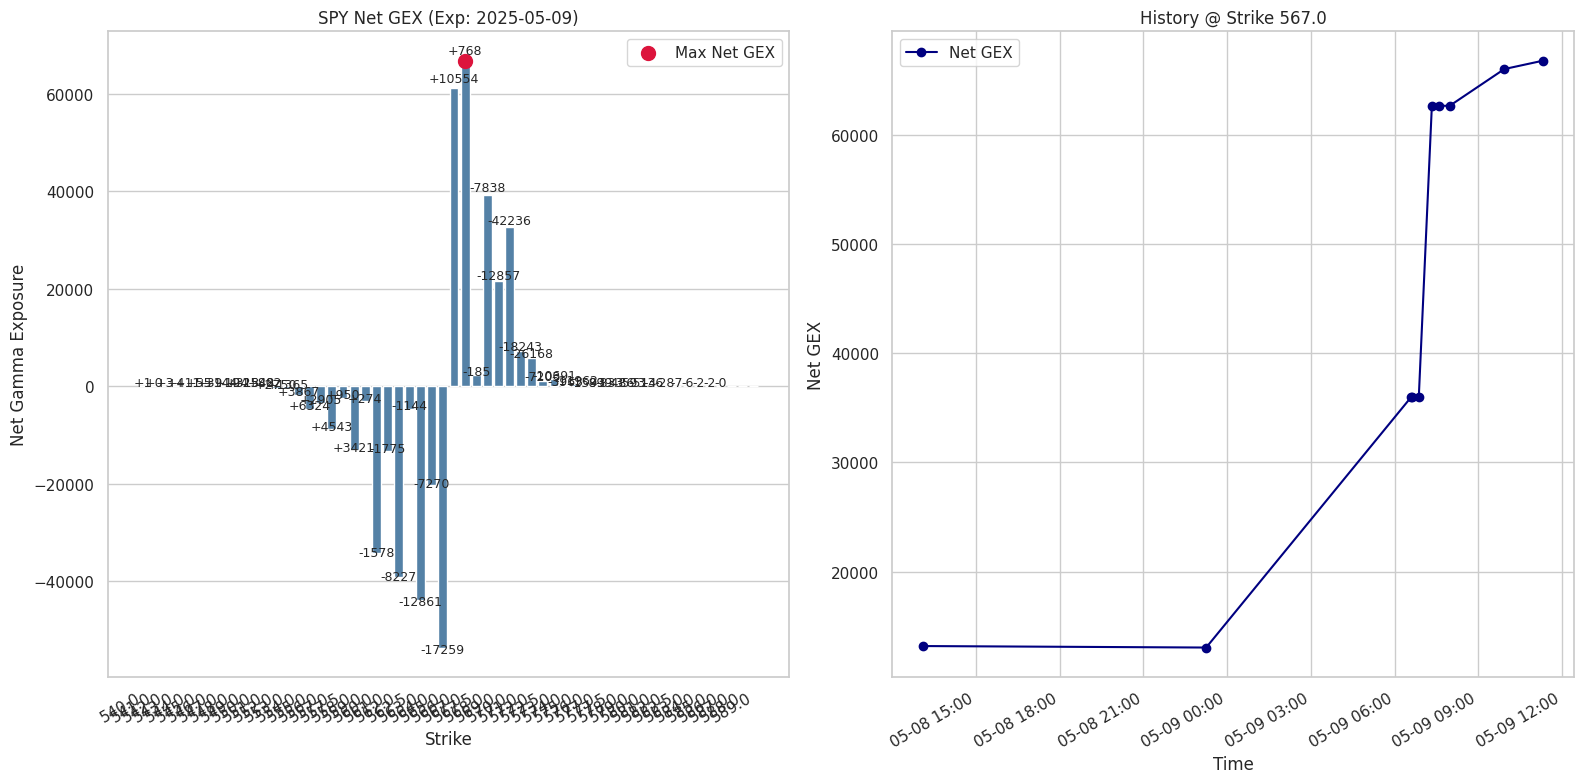

In [150]:

def compute_net_gamma_exposure(chain, S):
    """
    Filter strikes within S ± OFFSET, extract gamma from chain[i]['greeks']['gamma'],
    compute Gamma Exposure = γ × open_interest × contract_size,
    then Net GEX = call GEX – put GEX per strike.
    """
    rows = []
    for opt in chain:
        K       = opt["strike"]
        if not (S - OFFSET <= K <= S + OFFSET):
            continue

        # pull gamma from nested greeks dict
        gamma_api = opt.get("greeks", {}).get("gamma")
        if gamma_api is None:
            continue

        oi        = opt.get("open_interest", 0)
        multiplier= opt.get("contract_size", 100)
        gex       = gamma_api * oi * multiplier
        rows.append({
            "Strike": K,
            "GEX":    gex,
            "Side":   opt["option_type"].upper()
        })

    if not rows:
        return pd.DataFrame(columns=["Strike","Net GEX"])

    df = pd.DataFrame(rows)
    calls = df[df["Side"] == "CALL"].set_index("Strike")["GEX"]
    puts  = df[df["Side"] == "PUT"].set_index("Strike")["GEX"]
    net   = calls.sub(puts, fill_value=0).reset_index().rename(columns={0:"Net GEX"})
    net.columns = ["Strike","Net GEX"]
    return net.sort_values("Strike")


def cache_current_data(df_current, timestamp):
    """Append current df (with columns Strike, Net GEX) + Timestamp, keep last 10 batches."""
    df = df_current.copy()
    df["Timestamp"] = timestamp
    if os.path.exists(CACHE_FILE):
        cache = pd.read_csv(CACHE_FILE)
    else:
        cache = pd.DataFrame()
    cache = pd.concat([cache, df], ignore_index=True)
    cache["Timestamp"] = pd.to_datetime(cache["Timestamp"], errors="coerce")
    cache = cache.dropna(subset=["Timestamp"])
    times = cache["Timestamp"].drop_duplicates().nlargest(10)
    cache = cache[cache["Timestamp"].isin(times)]
    cache.to_csv(CACHE_FILE, index=False)
    return cache


def get_previous_query(df_cache, current_ts):
    """Return the df for the batch immediately before current_ts."""
    df = df_cache.copy()
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
    times = df["Timestamp"].drop_duplicates().sort_values(ascending=False)
    if len(times) < 2:
        return None
    prev = times[times < current_ts].max()
    return df[df["Timestamp"] == prev]


def plot_net_gamma_exposure(df_net_current, previous_df, S, ticker, expiration, df_cache):
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

    # ── LEFT PANEL ────────────────────────────────────────────────────────
    # 1) Make a copy and stringify the Strike so it's treated categorically
    df_plot = df_net_current.copy()
    df_plot['StrikeCat'] = df_plot['Strike'].map(lambda s: f"{s:.1f}")

    # 2) Draw the barplot using the categorical column
    sns.barplot(data=df_plot, x='StrikeCat', y='Net GEX', ax=ax1, color='steelblue')

    # 3) Draw the spot price as a vertical line at the matching category index
    spot_cat = f"{S:.1f}"
    if spot_cat in df_plot['StrikeCat'].values:
        idx = df_plot.index[df_plot['StrikeCat'] == spot_cat][0]
        ax1.axvline(idx, color='red', linestyle='--', linewidth=2, label=f"Spot={S:.2f}")

    # 4) Annotate deltas from previous query, if present
    if previous_df is not None:
        prev = previous_df.rename(columns={'Net GEX':'Net GEX_prev'})
        merged = df_plot.merge(prev, left_on='Strike', right_on='Strike')
        for _, row in merged.iterrows():
            d = row['Net GEX'] - row['Net GEX_prev']
            if abs(d) > 0.1:
                ax1.text(
                    row.name,                    # row.name is the int index
                    row['Net GEX'] * 1.02,
                    f"{d:+.0f}",
                    ha='center',
                    fontsize=9
                )

    # 5) Highlight the max Net GEX
    max_i = df_plot['Net GEX'].idxmax()
    ax1.scatter(
        max_i,
        df_plot.loc[max_i, 'Net GEX'],
        color='crimson',
        s=100,
        label='Max Net GEX'
    )

    ax1.set_title(f"{ticker} Net GEX (Exp: {expiration})")
    ax1.set_xlabel("Strike")
    ax1.set_ylabel("Net Gamma Exposure")
    ax1.legend(loc='upper right')
    ax1.set_xticklabels(df_plot['StrikeCat'], rotation=45, ha='right')

    # ── RIGHT PANEL ───────────────────────────────────────────────────────
    hist = df_cache.copy()
    hist['Timestamp'] = pd.to_datetime(hist['Timestamp'], errors='coerce')
    hist = hist.dropna(subset=['Timestamp'])
    max_strike = df_plot.loc[max_i, 'Strike']
    hist_strike = hist[hist['Strike']==max_strike].sort_values('Timestamp')

    ax2.set_title(f"History @ Strike {max_strike}")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Net GEX")

    if hist_strike.empty:
        ax2.text(0.5, 0.5, "No history", ha='center', va='center')
    else:
        ax2.plot(
            hist_strike['Timestamp'],
            hist_strike['Net GEX'],
            marker='o', color='navy', label='Net GEX'
        )
        ax2.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
        fig.autofmt_xdate()
        ax2.legend()

    plt.tight_layout()
    plt.show()

df_net = compute_net_gamma_exposure(chain, S)
ts = datetime.now()
df_cache= cache_current_data(df_net, ts)
prev    = get_previous_query(df_cache, ts)
plot_net_gamma_exposure(df_net, prev, S, TICKER, DATE, df_cache)

The IV skew at a given strike tells you whether puts or calls are trading richer in implied volatility.

A positive skew (IV_put > IV_call) means puts are more expensive → bearish tail risk premium.

A negative skew means calls are richer → bullish bias or “callers’ fear.”

Put/Call Volume Ratio > 1 means more trading interest in puts → bearish sentiment.

Put/Call OI Ratio > 1 means more open interest in puts → longer-term hedges or bearish bets.

When daily volume / open interest jumps above its 90th percentile, it signals unusual flow—often institutions entering or exiting positions.


In [151]:
df = pd.DataFrame(chain)
if 'greeks' in df.columns:
    greeks_df = pd.json_normalize(df.pop('greeks'))
    df = pd.concat([df, greeks_df], axis=1)

# 1) IV Skew using mid_iv
calls = df[df['option_type'] == 'call'][['strike', 'mid_iv']].rename(columns={'mid_iv': 'iv_call'})
puts  = df[df['option_type'] == 'put'][['strike', 'mid_iv']].rename(columns={'mid_iv': 'iv_put'})
iv_skew_df = pd.merge(calls, puts, on='strike', how='inner')
iv_skew_df['iv_skew'] = iv_skew_df['iv_put'] - iv_skew_df['iv_call']

# 2) Put/Call Volume & OI Ratios
total_put_vol = df[df['option_type'] == 'put']['volume'].sum()
total_call_vol = df[df['option_type'] == 'call']['volume'].sum()
put_call_vol_ratio = total_put_vol / total_call_vol if total_call_vol else np.nan

total_put_oi = df[df['option_type'] == 'put']['open_interest'].sum()
total_call_oi = df[df['option_type'] == 'call']['open_interest'].sum()
put_call_oi_ratio = total_put_oi / total_call_oi if total_call_oi else np.nan

# 3) Unusual Volume Spikes: volume / open_interest ratio
df['vol_oi_ratio'] = df['volume'] / df['open_interest'].replace(0, np.nan)
threshold = df['vol_oi_ratio'].quantile(0.90)
spikes_df = df[df['vol_oi_ratio'] >= threshold][
    ['symbol', 'expiration_date', 'option_type', 'strike', 
     'volume', 'open_interest', 'vol_oi_ratio']
]


# Display results

# print("IV Skew by Strike")
# display(iv_skew_df)
# print("Unusual Volume Spikes")
# display(spikes_df)

print(f"Put/Call Volume Ratio: {put_call_vol_ratio:.2f}")
print(f"Put/Call Open Interest Ratio: {put_call_oi_ratio:.2f}")
def plot_iv_skew(iv_skew_df, S):
    plt.figure(figsize=(8,4))
    plt.plot(iv_skew_df['strike'], iv_skew_df['iv_skew'], marker='o')
    plt.axhline(0, color='gray', linewidth=1)
    plt.axvline(S, color='red', linestyle='--', label=f"Spot = {S:.2f}")
    plt.title("IV Skew (Put IV – Call IV) by Strike")
    plt.xlabel("Strike")
    plt.ylabel("IV Skew")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def show_put_call_ratios(vol_ratio, oi_ratio):
    print(f"📈 Put/Call Volume Ratio: {vol_ratio:.2f}")
    print(f"📊 Put/Call OI Ratio:     {oi_ratio:.2f}")

def plot_put_call_ratios(vol_ratio, oi_ratio):
    labels = ['Volume', 'Open Interest']
    vals   = [vol_ratio, oi_ratio]
    colors = ['#d62728' if v>1 else '#1f77b4' for v in vals]  # red if >1
    plt.figure(figsize=(4,3))
    plt.bar(labels, vals, color=colors)
    plt.axhline(1, color='gray', linestyle='--')
    plt.title("Put/Call Ratios")
    plt.tight_layout()
    plt.show()

def plot_volume_spikes(spikes_df):
    spikes = spikes_df.sort_values('vol_oi_ratio', ascending=False).head(10)
    plt.figure(figsize=(8,4))
    plt.bar(
        spikes['strike'].astype(str),
        spikes['vol_oi_ratio'],
        color='orange'
    )
    plt.xticks(rotation=45)
    plt.title("Top 10 Unusual Volume/OI Spikes")
    plt.xlabel("Strike")
    plt.ylabel("Volume / OpenInterest")
    plt.tight_layout()
    plt.show()

Put/Call Volume Ratio: 0.85
Put/Call Open Interest Ratio: 2.33


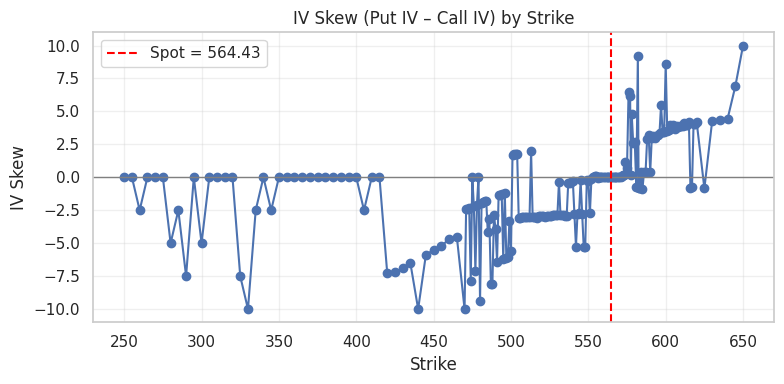

📈 Put/Call Volume Ratio: 0.85
📊 Put/Call OI Ratio:     2.33


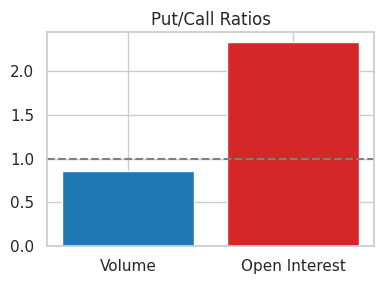

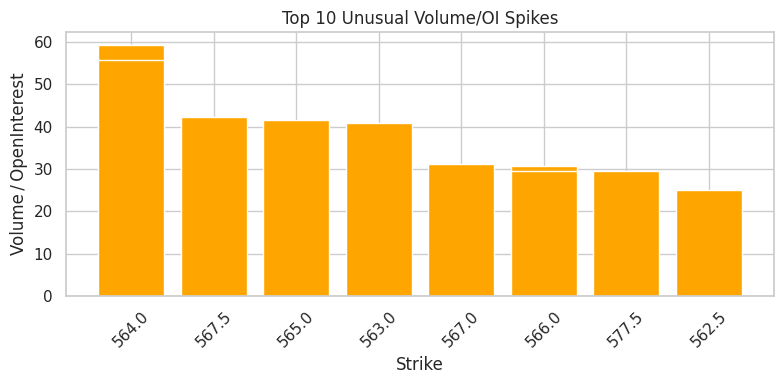

In [152]:
plot_iv_skew(iv_skew_df, S)
show_put_call_ratios(put_call_vol_ratio, put_call_oi_ratio)
plot_put_call_ratios(put_call_vol_ratio, put_call_oi_ratio)
plot_volume_spikes(spikes_df)

In [13]:
spikes_df

,symbol,expiration_date,option_type,strike,volume,open_interest,vol_oi_ratio
224,SPY250509P00538000,2025-05-09,put,538.0,1303,5854,0.222583
262,SPY250509P00557000,2025-05-09,put,557.0,2246,7454,0.301315
266,SPY250509P00558000,2025-05-09,put,558.0,1663,7744,0.214747
268,SPY250509P00559000,2025-05-09,put,559.0,1303,4972,0.262068
270,SPY250509P00560000,2025-05-09,put,560.0,2923,15833,0.184614
272,SPY250509P00561000,2025-05-09,put,561.0,1410,4832,0.291805
274,SPY250509P00562000,2025-05-09,put,562.0,1708,7703,0.221732
277,SPY250509P00562500,2025-05-09,put,562.5,1705,3606,0.472823
278,SPY250509P00563000,2025-05-09,put,563.0,2077,6460,0.321517
280,SPY250509P00564000,2025-05-09,put,564.0,3293,5374,0.612765
